# Southern Ocean average Surface Sea Temperature
Plots of the climatology for the Southern Ocean average surface sea temperature (SST). The [Data analysis](#Data-Analysis) can be found in the bottom half of the document.

#### Dask

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33832")
client

Client Scheduler: tcp://127.0.0.1:33832 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 9 Memory: 57.98 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
#import cdstoolbox as ct
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading ESM data</b>

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[1]), consolidated=True)
dataAreaRaw = dsArea.areacello

for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets

dfESMLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded into dfESMLat.")

ESM data sucessfully loaded into dfESMLat.


<br>
<b>Loading Mask</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask data loaded into oceanMask.")

Mask data loaded into oceanMask.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
    <li>dateCheck1 - Takes in a single date and checks to see if it is inside the data set. If not then the nearest valid date is returned
    <li>dateCheck2 - Takes in a pair of dates (start and end) and checks to see if they are ordered correctly (start before end) and that both dates are inside the data set. If not then the nearest valid dates are returned.
    <li>getSurfaceData - Takes input data set, checks target date slice validity, and returns surface (lev = 5.0) data for selected data sets (use "All" for all).
</ul>

In [6]:
def dateCheck1(Date):
    '''Takes date input, check to ensure that date is valid for the data set, modifying it if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(Date ,'M') < globalStartDate:
        Date = globalStartDateStr
    elif np.datetime64(Date ,'M') > globalEndDateOut:
        Date = globalEndDateInStr
    return Date


def dateCheck2(startDate, endDate):
    '''Takes start and end date input, check to ensure that both dates are valid for the data set, modifying them if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(startDate ,'M') > np.datetime64(endDate ,'M'):
        startDate, endDate = endDate, startDate
    if np.datetime64(startDate ,'M') < globalStartDate:
        startDate = globalStartDateStr
        if np.datetime64(endDate ,'M') < globalStartDate:
            endDate = globalStartDateStr
    if np.datetime64(endDate ,'M') > globalEndDateOut:
        endDate = globalEndDateOutStr
        if np.datetime64(startDate ,'M') > globalEndDateOut:
            startDate = globalEndDateInStr
    return startDate, endDate


def getSurfaceData(dataSet, startDate, endDate, runID, plotNo):
    startDate, endDate = dateCheck2(startDate, endDate)
    dataSetTrimmed = dataSet.copy()
    dataSetTrimmed = dataSetTrimmed.sel(time=slice(startDate, endDate))
    try:
        dataSetTrimmed = dataSetTrimmed.sel(lev = 5.0)
        dataSetTrimmed = dataSetTrimmed.reset_coords(drop=True)
    except:
        pass
    if ((runID == "All" or runID == "all") or (runID > fileCount)):
        dataSetTrimmed = dataSetTrimmed.mean(RunID, keep_attrs=True)
    else:
        dataSetTrimmed = dataSetTrimmed.sel(RunID=runID)
    return dataSetTrimmed
    
print("Calculation functions defined")

Calculation functions defined


<br>
<b>Creating masked copy of dataset</b>

In [7]:
dfESMLatM = dfESMLat.copy()
dfESMLatM = dfESMLatM * oceanMask
print("dfESMLat multiplied by mask and stored in dfESMLatM.")

dfESMLat multiplied by mask and stored in dfESMLatM.


<br>
<b>Creating months array and weights</b>

In [8]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
weights = np.cos(np.deg2rad(dfESMLat.lat))
weights.name = "Weights"
weightsM = np.cos(np.deg2rad(dfESMLatM.lat))
weightsM.name = "Weights Masked"
print("Months and weights created, stored in months and (weights, weightsM) respectively.")

Months and weights created, stored in months and (weights, weightsM) respectively.


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
    
</ul>

In [9]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def timePlot(dataSetMean, title, plotNo):
    plt.figure(plotNo)
    plt.plot(months, dataSetMean.values, label = dataSetMean.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("Temperature (°C)")
    plt.title(str(title))
    
def timePlotStd(dataSetMean, dataSetError, title, plotNo):
    plt.figure(plotNo, figsize = (10,10))
    plt.errorbar(months, dataSetMean.values, yerr=dataSetError.values, label = dataSetMean.name, capsize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Data Analysis

<b>Calculating SST data sets and respective means and errors to be plotted</b>

In [10]:
decadeSSTData = getSurfaceData(dfESMLat, '2005-01', '2014-12', 0, 1)
decadeSSTDataM = decadeSSTData*oceanMask
decadeSSTDataWeighted = decadeSSTData.weighted(weights)
decadeSSTDataWeightedM = decadeSSTData.weighted(weightsM)
decadeSSTAreaMean = decadeSSTData.mean(('lat', 'lon'), keep_attrs=True)
decadeSSTAreaMeanWeighted = decadeSSTDataWeighted.mean(('lat', 'lon'), keep_attrs=True)
decadeSSTAreaMeanWeightedM = decadeSSTDataWeightedM.mean(('lat', 'lon'), keep_attrs=True)

decadeSSTAreaMeanGrouped = decadeSSTAreaMean.groupby("time.month")
decadeSSTMean = decadeSSTAreaMeanGrouped.mean('time', keep_attrs=True)
decadeSSTstd = decadeSSTAreaMeanGrouped.std('time', keep_attrs=True)

decadeSSTMean.name = "Surface Temperature Unweighted"


decadeSSTAreaMeanGroupedWeighted = decadeSSTAreaMeanWeighted.groupby("time.month")
decadeSSTMeanWeighted = decadeSSTAreaMeanGroupedWeighted.mean('time', keep_attrs=True)
decadeSSTstdWeighted = decadeSSTAreaMeanGroupedWeighted.std('time', keep_attrs=True)

decadeSSTMeanWeighted.name = "Surface Temperature Weighted"

decadeSSTAreaMeanGroupedWeightedM = decadeSSTAreaMeanWeightedM.groupby("time.month")
decadeSSTMeanWeightedM = decadeSSTAreaMeanGroupedWeightedM.mean('time', keep_attrs=True)
decadeSSTstdWeightedM = decadeSSTAreaMeanGroupedWeightedM.std('time', keep_attrs=True)

decadeSSTMeanWeightedM.name = "Surface Temperature Mask Weighted"

<br>
<b>Plotting SST mean for the last decade</b>

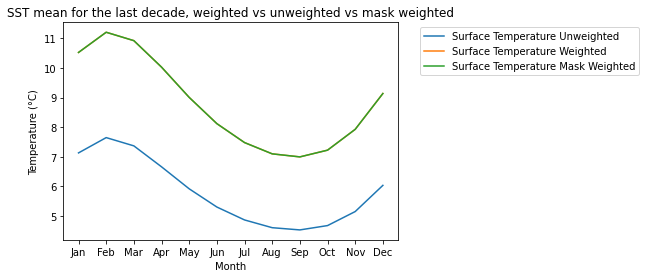

In [11]:
timePlot(decadeSSTMean, "SST mean for the last decade, unweighted", 1)
timePlot(decadeSSTMeanWeighted, "SST mean for the last decade, weighted vs unweighted", 1)
timePlot(decadeSSTMeanWeightedM, "SST mean for the last decade, weighted vs unweighted vs mask weighted", 1)

<br>
<b>Plotting SST mean for the last decade with error bars</b>

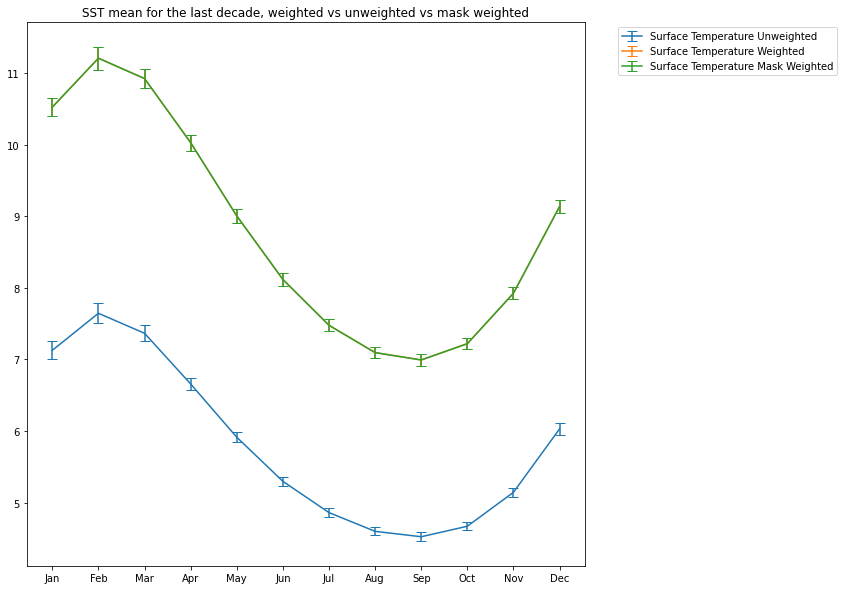

In [12]:
timePlotStd(decadeSSTMean, decadeSSTstd, "SST mean for last decade, unweighted", 1)
timePlotStd(decadeSSTMeanWeighted, decadeSSTstdWeighted, "SST mean for the last decade, weighted vs unweighted", 1)
timePlotStd(decadeSSTMeanWeightedM, decadeSSTstdWeightedM, "SST mean for the last decade, weighted vs unweighted vs mask weighted", 1)